In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import random

from models.mnist_model import Generator, Discriminator, DHead, QHead
from dataloader import get_data
from utils import *
from config import params
CUDA_LAUNCH_BLOCKING = 1
if(params['dataset'] == 'MNIST'):
    from models.mnist_model import Generator, Discriminator, DHead, QHead
elif(params['dataset'] == 'HGD'):
    from models.hgd_model2 import Generator, Discriminator, DHead, QHead, AE, LogitHead
elif(params['dataset'] == 'SVHN'):
    from models.svhn_model import Generator, Discriminator, DHead, QHead, AE
elif(params['dataset'] == 'CelebA'):
    from models.celeba_model import Generator, Discriminator, DHead, QHead
elif(params['dataset'] == 'FashionMNIST'):
    from models.mnist_model import Generator, Discriminator, DHead, QHead


In [2]:

# Set random seed for reproducibility.
seed = 1123
random.seed(seed)
torch.manual_seed(seed)
print("Random Seed: ", seed)

# Use GPU if available.
device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
print(device, " will be used.\n")
import warnings
warnings.filterwarnings("ignore")
dataloader = get_data(params['dataset'], params['batch_size'])

# Set appropriate hyperparameters depending on the dataset used.
# The values given in the InfoGAN paper are used.
# num_z : dimension of incompressible noise.
# num_dis_c : number of discrete latent code used.
# dis_c_dim : dimension of discrete latent code.
# num_con_c : number of continuous latent code used.
if (params['dataset'] == 'HGD'):
    params['num_z'] = 256
    params['num_dis_c'] = 1
    params['dis_c_dim'] = 10
    params['num_con_c'] = 4
if(params['dataset'] == 'MNIST'):
    params['num_z'] = 62
    params['num_dis_c'] = 1
    params['dis_c_dim'] = 10
    params['num_con_c'] = 2
elif(params['dataset'] == 'SVHN'):
    params['num_z'] = 124
    params['num_dis_c'] = 4
    params['dis_c_dim'] = 10
    params['num_con_c'] = 4
elif(params['dataset'] == 'CelebA'):
    params['num_z'] = 128
    params['num_dis_c'] = 10
    params['dis_c_dim'] = 10
    params['num_con_c'] = 0
elif(params['dataset'] == 'FashionMNIST'):
    params['num_z'] = 62
    params['num_dis_c'] = 1
    params['dis_c_dim'] = 10
    params['num_con_c'] = 2

# Plot the training images.

sample_batch = next(iter(dataloader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(
    sample_batch[0].to(device)[ : 100], nrow=10, padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.savefig('results/Training Images {}'.format(params['dataset']))
plt.close('all')


Random Seed:  1123
cuda:0  will be used.



In [3]:

# Initialise the network.
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

netDG = AE().to(device)
netDG.apply(weights_init)

netLogit = LogitHead().to(device)

discriminator = Discriminator().to(device)
discriminator.apply(weights_init)
print(discriminator)

netD = DHead().to(device)
netD.apply(weights_init)
print(netD)

netQ = QHead().to(device)
netQ.apply(weights_init)
print(netQ)



# Loss for discrimination between real and fake images.
criterionD = nn.BCELoss()
# Loss for discrete latent code.
criterionQ_dis = nn.CrossEntropyLoss()
# Loss for continuous latent code.
criterionQ_con = NormalNLLLoss()

criterion_mse = nn.MSELoss()
# Adam optimiser is used.
optimD = optim.Adam([{'params': discriminator.parameters()}, {'params': netD.parameters()}], lr=params['learning_rate'], betas=(params['beta1'], params['beta2']))
optimG = optim.Adam([{'params': netG.parameters()}, {'params': netQ.parameters()}], lr=params['learning_rate_g'], betas=(.4, params['beta2']))
# schedulerD = optim.ReduceLROnPlateau(optimD, 'min')
# schedulerG = optim.ReduceLROnPlateau(optimG, 'min')
# Fixed Noise
z = torch.randn(100, params['num_z'], device=device)
fixed_noise = z
if(params['num_dis_c'] != 0):
    idx = np.arange(params['dis_c_dim']).repeat(10)
    dis_c = torch.zeros(100, params['num_dis_c'], params['dis_c_dim'], device=device)
    for i in range(params['num_dis_c']):
        dis_c[torch.arange(0, 100), i, idx] = 1.0

    dis_c = dis_c.view(100, -1)

    # fixed_noise = torch.cat((fixed_noise, dis_c), dim=1)
fixed_idx= torch.tensor(idx,device = device,dtype = torch.long).reshape(-1,1)
if(params['num_con_c'] != 0):
    con_c = torch.rand(100, params['num_con_c'],  device=device) * 2 - 1
    # fixed_noise = torch.cat((fixed_noise, con_c), dim=1)

real_label = 1
fake_label = 0.0

# List variables to store results pf training.
img_list = []
G_losses = []
D_losses = []




Generator(
  (noise_latent): Linear(in_features=256, out_features=16384, bias=False)
  (label): Linear(in_features=1, out_features=64, bias=False)
  (Elabel): Embedding(10, 1)
  (cont_latent): Linear(in_features=4, out_features=256, bias=False)
  (tconv1): ConvTranspose2d(261, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(261, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)
Discriminator(
  (label): Linear(in_features=1, out_features=4096, bias=True)
  (Elabel): Embedding(10, 1)
  (conv1): Conv2d(2, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=Fals

In [4]:
print("-"*25)
print("Starting Training Loop...\n")
print('Epochs: %d\nDataset: {}\nBatch Size: %d\nLength of Data Loader: %d'.format(params['dataset']) % (params['num_epochs'], params['batch_size'], len(dataloader)))
print("-"*25)

start_time = time.time()
iters = 0

for epoch in range(params['num_epochs']):
    epoch_start_time = time.time()

    for i, (data, gt_labels) in enumerate(dataloader, 0):
        # Get batch size
        b_size = data.size(0)
        # Transfer data tensor to GPU/CPU (device)
        real_data = data.to(device)
        gt_labels = gt_labels.unsqueeze(1).to(device,dtype = torch.long)

        # Updating discriminator and DHead
        optimD.zero_grad()
        # Real data
        label = torch.full((b_size, ), real_label, device=device,dtype=torch.float32)
        # print(real_data.shape,'realdata')
        # print(real_data.shape)
        output1 = discriminator(real_data, gt_labels)
        # print(output1.shape,'output1')
        # output_real_DG = netDG(output1)
        # print(output_real_DG.shape,'dgshape')
        # print(real_data.shape,output_real_DG.shape)
        # loss_real_ae= criterion_mse(real_data,output_real_DG)
        probs_real = netD(output1).view(-1)
        # classifier,_,_ = netQ(output1)

        # print(label.dtype,probs_real.dtype)
        # print(classifier.shape, gt_labels.shape)
        # lossR_class = criterionQ_dis(classifier,gt_labels.squeeze())
        # print(classifier,gt_labels)
        loss_real = criterionD(probs_real, label)
        # Calculate gradients.
        # loss_real+=loss_real_ae
        lossR= loss_real# + lossR_class
        lossR.backward()

        # Fake data
        label.fill_(fake_label)
        noise, idx, gt_fake, continuous = noise_sample(params['num_dis_c'], params['dis_c_dim'], params['num_con_c'], params['num_z'], b_size, device)
        target = torch.LongTensor(idx).to(device)
        fake_data = netG(noise.squeeze((2,3)),target.view(-1,1),continuous)
        # print(fake_data.shape,'fake_data1')
        output2 = discriminator(fake_data.detach(),target.view(-1,1))
        # classifier_fake,_,_ = netQ(output2)
        # print(classifier.shape,target_d.shape)
        # output_fake_DG = netDG(output2)
        # print(output_real_DG.shape,'dgshape')
        # print(real_data.shape,output_real_DG.shape)
        # loss_fake_ae= criterion_mse(fake_data.detach(),output_fake_DG)
        # lossF_class = criterionQ_dis(classifier_fake,target.reshape(gt_labels.shape))


        probs_fake = netD(output2).view(-1)
        loss_fake = criterionD(probs_fake, label)
        # Calculate gradients.
        # lossF =loss_fake + lossF_class# + loss_fake_ae
        loss_fake.backward()
       
     
        # Net Loss for the discriminator
        D_loss = loss_fake + loss_real
        # Update parameters
        optimD.step()

        # Updating Generator and QHead
        optimG.zero_grad()
        
        # Fake data treated as real.
        # print(fake_data.shape,'fake data shpe')
        output = discriminator(fake_data,target.view(-1,1))
        # print(output, 'output discrim')
        label.fill_(real_label)
        # fake_logit = netLogit(output)

        probs_fake = netD(output).view(-1)
        #output_fake_DG = netDG(output)
        #loss_fake_ae= criterion_mse(fake_data,output_fake_DG)
        gen_loss = criterionD(probs_fake, label)
        q_logits, q_mu, q_var = netQ(output)
        
        # gen_dis_loss = criterionQ_dis(fake_logit,q_logits)

        # Calculating loss for discrete latent code.
        # dis_loss = 0
        dis_loss = criterionQ_dis(q_logits,target.to(dtype=torch.long).squeeze())
        # for j in range(params['num_dis_c']):
        #     dis_loss += criterionQ_dis(q_logits[:, j*10 : j*10 + 10], target[j])

        # Calculating loss for continuous latent code.
        con_loss = 0
        if (params['num_con_c'] != 0):
            con_loss = criterionQ_con(continuous, q_mu, q_var)

        # Net loss for generator.
        G_loss = gen_loss + dis_loss  + con_loss#+  loss_fake_ae*.5+dis_loss
        # print(G_loss)
        # Calculate gradients.
        G_loss.backward()
        # Update parameters.
        # torch.nn.utils.clip_grad_norm_(netG.parameters(), 1)
        optimG.step()

        # Check progress of training.
        if i != 0 and i%100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch+1, params['num_epochs'], i, len(dataloader), 
                   D_loss.item(), G_loss.item()))

        # Save the losses for plotting.
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

        iters += 1

    epoch_time = time.time() - epoch_start_time
    print("Time taken for Epoch %d: %.2fs" %(epoch + 1, epoch_time))
    # Generate image after each epoch to check performance of the generator. Used for creating animated gif later.
    with torch.no_grad():
        gen_data = netG(z,fixed_idx,con_c).detach().cpu()
    img_list.append(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True))

    # Generate image to check performance of generator.
    if((epoch+1) == 1 or (epoch+1) % 10==0):
        with torch.no_grad():
            gen_data = netG(z,fixed_idx,con_c).detach().cpu()
        plt.figure(figsize=(10, 10))
        plt.axis("off")
        plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))
        plt.savefig("results/Epoch_%d_{}".format(params['dataset']) %(epoch+1))
        plt.close('all')

    # Save network weights.
    if (epoch+1) % params['save_epoch'] == 0:
        torch.save({
            'netG' : netG.state_dict(),
            'discriminator' : discriminator.state_dict(),
            'netD' : netD.state_dict(),
            'netQ' : netQ.state_dict(),
            'optimD' : optimD.state_dict(),
            'optimG' : optimG.state_dict(),
            'params' : params
            }, 'checkpoint/model_epoch_%d_{}'.format(params['dataset']) %(epoch+1))

training_time = time.time() - start_time
print("-"*50)
print('Training finished!\nTotal Time for Training: %.2fm' %(training_time / 60))
print("-"*50)

-------------------------
Starting Training Loop...

Epochs: 500
Dataset: HGD
Batch Size: 64
Length of Data Loader: 250
-------------------------
[1/500][100/250]	Loss_D: 1.3185	Loss_G: 3.7833
[1/500][200/250]	Loss_D: 1.1006	Loss_G: 3.4342
Time taken for Epoch 1: 9.82s
[2/500][100/250]	Loss_D: 0.7659	Loss_G: 1.2438
[2/500][200/250]	Loss_D: 0.6806	Loss_G: 1.0037
Time taken for Epoch 2: 8.82s
[3/500][100/250]	Loss_D: 0.9550	Loss_G: 3.2702
[3/500][200/250]	Loss_D: 0.8103	Loss_G: 1.1337
Time taken for Epoch 3: 8.79s
[4/500][100/250]	Loss_D: 0.7604	Loss_G: 0.1891
[4/500][200/250]	Loss_D: 0.8246	Loss_G: 2.4426
Time taken for Epoch 4: 9.03s
[5/500][100/250]	Loss_D: 0.7033	Loss_G: 0.5496
[5/500][200/250]	Loss_D: 0.7142	Loss_G: 1.1414
Time taken for Epoch 5: 8.87s
[6/500][100/250]	Loss_D: 0.6254	Loss_G: 0.9760
[6/500][200/250]	Loss_D: 0.6630	Loss_G: 2.1441
Time taken for Epoch 6: 8.91s
[7/500][100/250]	Loss_D: 0.6246	Loss_G: 1.0024
[7/500][200/250]	Loss_D: 0.8965	Loss_G: 1.5015
Time taken for E

MovieWriter imagemagick unavailable; using Pillow instead.


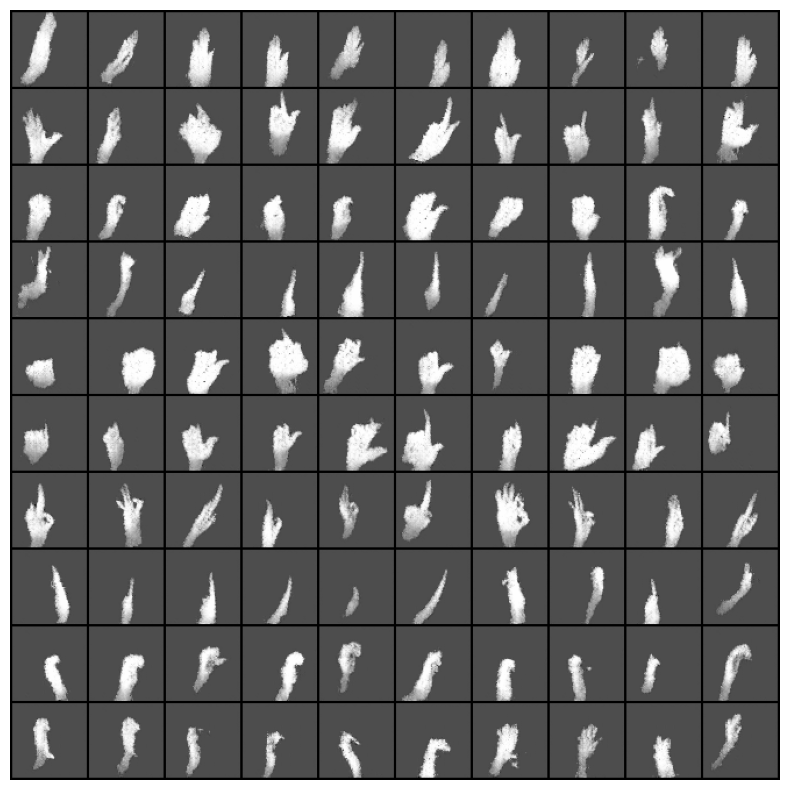

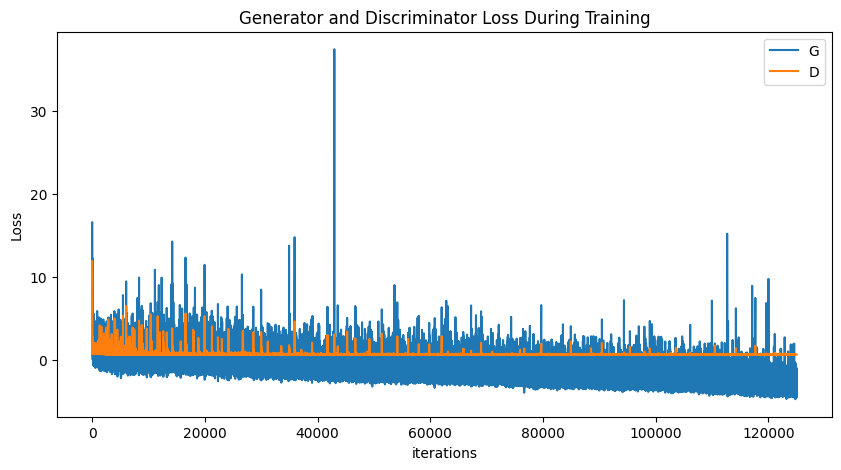

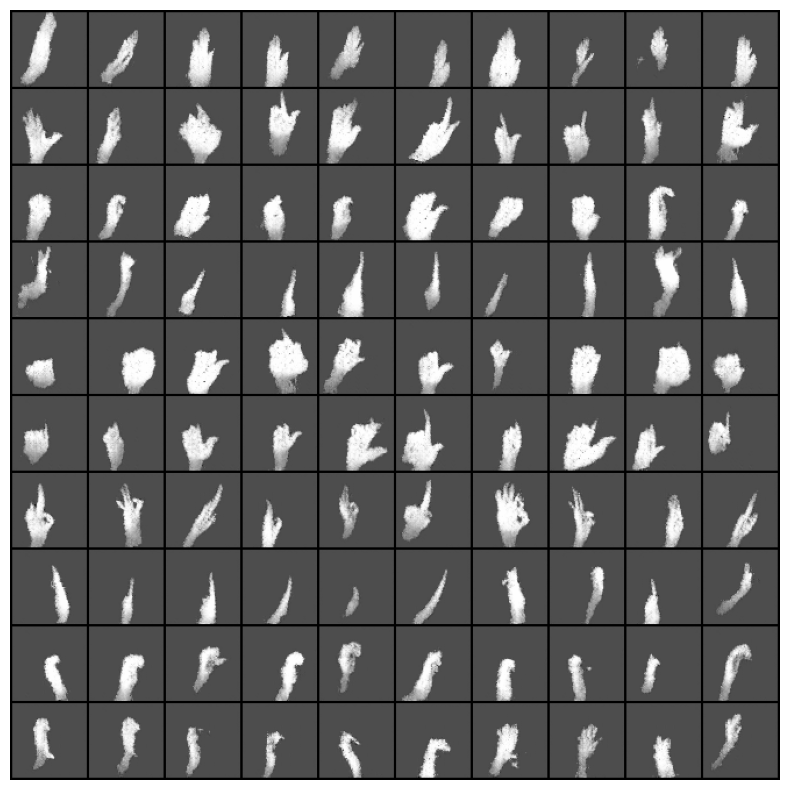

In [ ]:

# Generate image to check performance of trained generator.
with torch.no_grad():
    gen_data = netG(z,fixed_idx,con_c).detach().cpu()
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))
plt.savefig("results/Epoch_%d_{}".format(params['dataset']) %(params['num_epochs']))

# Save network weights.
torch.save({
    'netG' : netG.state_dict(),
    'discriminator' : discriminator.state_dict(),
    'netD' : netD.state_dict(),
    'netQ' : netQ.state_dict(),
    'optimD' : optimD.state_dict(),
    'optimG' : optimG.state_dict(),
    'params' : params
    }, 'checkpoint/model_final_{}'.format(params['dataset']))


# Plot the training losses.
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("results/Loss Curve {}".format(params['dataset']))

# Animation showing the improvements of the generator.
fig = plt.figure(figsize=(10,10))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
anim.save('results/infoGAN_{}.gif'.format(params['dataset']), dpi=80, writer='imagemagick')
plt.show()

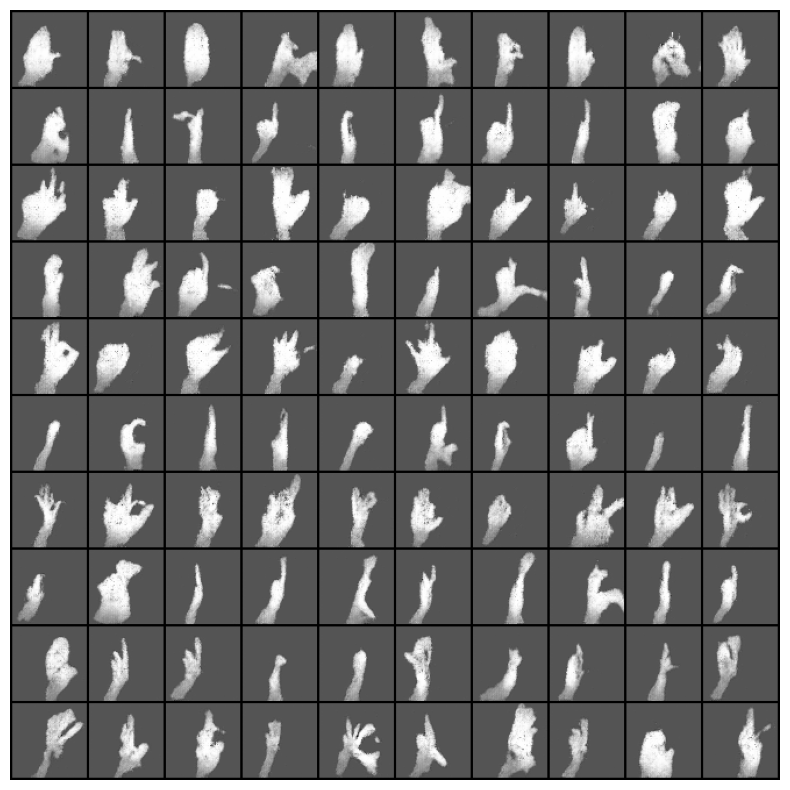

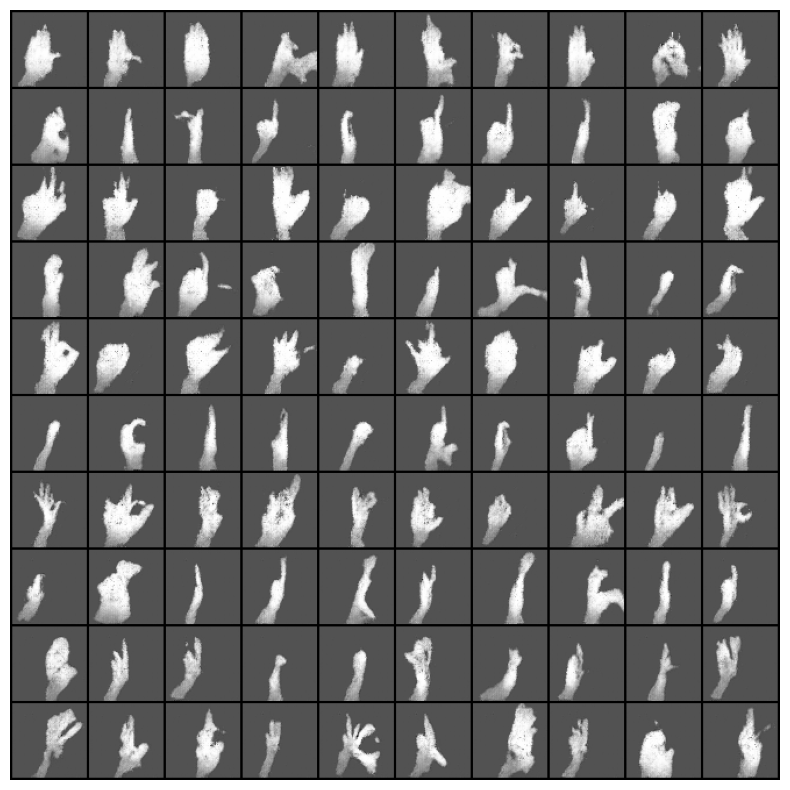

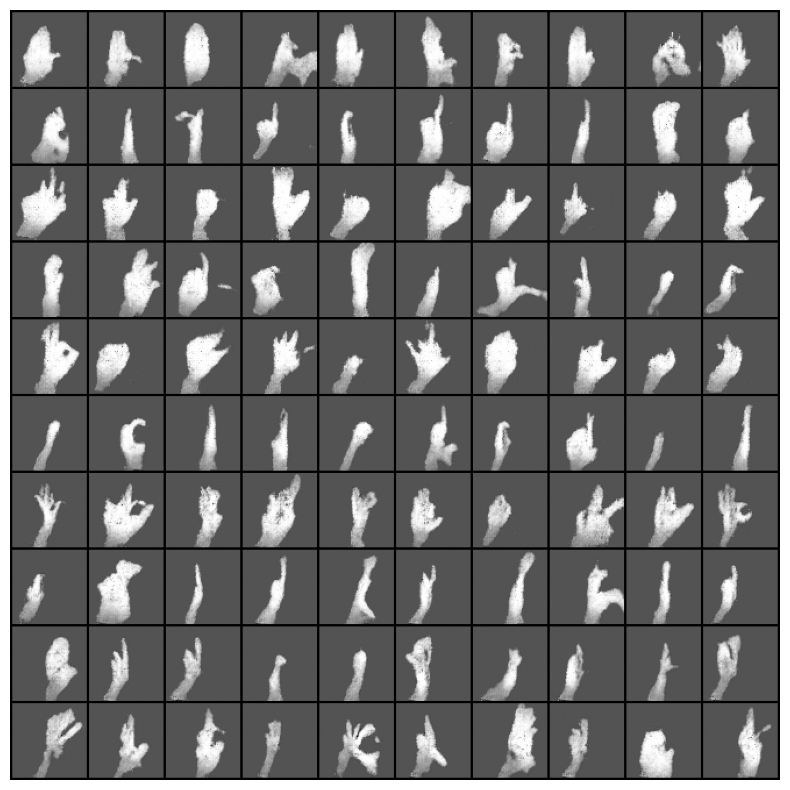

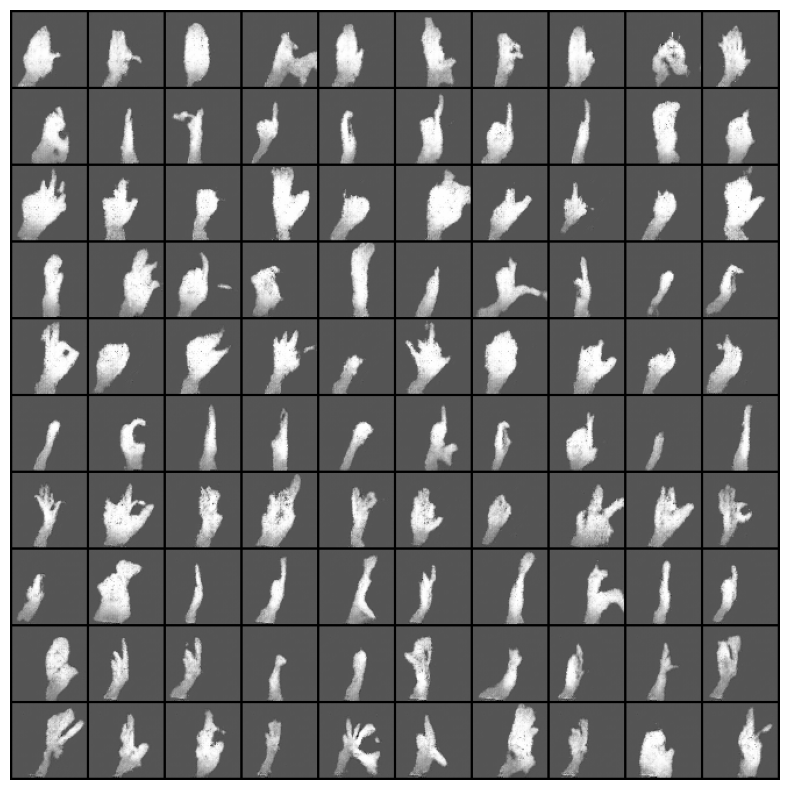

In [4]:
import argparse

import torch
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

# parser = argparse.ArgumentParser()
# parser.add_argument('-load_path', required=True, help='Checkpoint to load path from')
# args = parser.parse_args()

load_path = 'checkpoint/model_final_HGD2'

from models.hgd_model2 import Generator

# Load the checkpoint file
state_dict = torch.load(load_path)

# Set the device to run on: GPU or CPU.
device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
# Get the 'params' dictionary from the loaded state_dict.
params = state_dict['params']

# Create the generator network.
netG = Generator().to(device)
# Load the trained generator weights.
netG.load_state_dict(state_dict['netG'])
# print(netG)

c = np.linspace(-2, 2, 10).reshape(1, -1)
c = np.repeat(c, 10).reshape(-1, 1)
c = torch.from_numpy(c).float().to(device)
c = c.view(-1, 1)
# print(c.shape,'cshape')
zeros = torch.zeros(100, 1, device=device)
# Continuous latent code.
c2 = torch.cat((zeros, zeros,zeros,zeros), dim=1)
c3 = torch.cat((zeros, c,zeros,zeros), dim=1)
c4 = torch.cat((zeros,zeros,c, zeros), dim=1)
c5 = torch.cat((zeros,zeros,zeros, c), dim=1)
# print(c2)
# print(c2.shape,'c2shape')
idx = np.arange(10).repeat(10)
dis_c = torch.zeros(100, 8, 10, 1, device=device)
for i in range(8):
    dis_c[torch.arange(0, 100),i, idx] = .9
# Discrete latent code.
c1 = dis_c.view(100, -1, 1, 1)
# print(c1,'c1')
z = torch.randn(100, 256, device=device)
idx = torch.tensor(idx,device=device,dtype=torch.long).unsqueeze(1)
# print(z.dtype,idx.dtype,c2.dtype)
# To see variation along c2 (Horizontally) and c1 (Vertically)




# Generate image.
with torch.no_grad():
    generated_img1 = netG(z,idx,c2).detach().cpu()
# Display the generated image.
fig = plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(generated_img1, nrow=10, padding=2, normalize=True), (1,2,0)))
plt.show()

# Generate image.
with torch.no_grad():
    generated_img2 = netG(z,idx,c3).detach().cpu()
# Display the generated image.
fig = plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(generated_img2, nrow=10, padding=2, normalize=True), (1,2,0)))
plt.show()


with torch.no_grad():
    generated_img1 = netG(z,idx,c4).detach().cpu()
# Display the generated image.
fig = plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(generated_img1, nrow=10, padding=2, normalize=True), (1,2,0)))
plt.show()

# Generate image.
with torch.no_grad():
    generated_img2 = netG(z,idx,c5).detach().cpu()
# Display the generated image.
fig = plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(generated_img2, nrow=10, padding=2, normalize=True), (1,2,0)))
plt.show()